# Домашнее задание 2. Основные понятия математичеseedй статистики
Ковалев Даниил, СКБ171

### Импортирование нужных модулей и вспомогательные функции

In [1]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import os
from scipy import special, stats
from scipy.stats import pearsonr, mstats
from bisect import bisect_left, bisect_right
import functools
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 16})
sample_count = [5, 10, 100, 10**3, 10**5]

Функция для генерации выборок

In [3]:
def generate_samples(function, **kwargs):
    ret = {}
    for size in sample_count:
        ret[size] = [function(size=size, **kwargs) for i in range(5)]
    return ret

Функция, принимающая на вход вариационный ряд выборки и возвращающая ЭФР

In [4]:
def build_edf(emperical_data, return_y=False):
    length = len(emperical_data)
    if length == 0:
        raise ValueError("Emperical data must have length 1 or more")
    y_values = []
    prev = None
    counter, total = 0, 0
    for entry in emperical_data:
        if prev is None:
            prev = entry
        if entry == prev:
            counter += 1
        else:
            y_values += counter * [total / length]
            prev = entry
            counter = 1
        total += 1
    y_values += counter * [total / length]
    
    if return_y:
        return y_values

    def edf(x, emperical_data=emperical_data, y_values=y_values):
        if x < emperical_data[0]:
            return 0.0
        return y_values[bisect_right(emperical_data, x) - 1]
    
    return edf

Функция для вывода графиков ТФР и ЭФР из п. 2.2

In [5]:
def plot_all(var_series, cdf, x_values, x_ticks=None, **kwargs):
    for sample_size, samples in var_series.items():
        plt.figure(figsize=(25, 4.5))
        plt.suptitle('Графики ЭФР и ТФР для выборок объема {}'.format(sample_size), fontsize=15, y=1)
        pos = 101 + 10 * len(samples)
        plot_positions = range(101 + 10 * len(samples), 101 + 11 * len(samples))
        for i, pos in enumerate(plot_positions):
            plt.subplot(pos)
            if x_ticks is not None:
                plt.xticks(x_ticks)
            plt.plot(x_values, cdf(x_values, **kwargs), label='ТФР')
            edf = build_edf(samples[i])
            plt.plot(x_values, [edf(point) for point in x_values], label='ЭФР')
            plt.legend()
        plt.show()

Функция для нахождения верхней границы разности между двумя ЭФР (п. 2.2). Алгоритм основан на том, что значение разности меняется только в точках из data1 и data2, где data1 и data2 - вариационные ряды выборок

In [6]:
def find_max_diff(data1, data2):
    i, j = 0, 0
    n, m = len(data1), len(data2)
    def find_next(i, j, n, m):
        new = -1
        if i < n and j < m:
            if data1[i] < data2[j]:
                new = data1[i]
                i += 1
            else:
                new = data2[j]
                j += 1
        elif i < n:
            new = data1[i]
            i += 1
        elif j < m:
            new = data2[j]
            j += 1
        while i < n and data1[i] == new:
            i += 1
        while j < m and data2[j] == new:
            j += 1
        return (i, j)
    ret = 0
    while (i, j) != (n, m):
        ret = max(ret, abs(i / n - j / m))
        i, j = find_next(i, j, n, m)
    return ret

Функции для нахождения квантилей для непрерывного и дискретного распределений (п. 2.3). Получение ответа происходит при помощи бинарного поиска.

In [7]:
def find_quantile_continuous_tdf(tdf, quantile, left, right, precision=0.001, **kwargs):
    if quantile < 0.0 or quantile > 1.0:
        raise ValueError("Invalid quantile {}".format(quantile))
    left_y, right_y = tdf(left, **kwargs), tdf(right, **kwargs)
    while max(right - left, right_y - left_y) > precision:
        middle = (left + right) / 2
        if tdf(middle, **kwargs) < quantile:
            left = middle
        else:
            right = middle
        left_y, right_y = tdf(left, **kwargs), tdf(right, **kwargs)
    return (left + right) / 2

In [8]:
def find_quantile_discrete_tdf(tdf, quantile, left, right, precision=0.001, **kwargs):
    if quantile < 0.0 or quantile > 1.0:
        raise ValueError("Invalid quantile {}".format(quantile))
    left_y, right_y = tdf(left, **kwargs), tdf(right, **kwargs)
    while right - left > 1 and max(right - left, right_y - left_y) > precision:
        middle = (left + right) // 2
        if tdf(middle, **kwargs) < quantile:
            left = middle
        else:
            right = middle
        left_y, right_y = tdf(left, **kwargs), tdf(right, **kwargs)
    return right

Удобная функция вывода квантилей по вариационным рядам выборок

In [9]:
def find_all_edf_quantiles(var_series, quantiles=[0.1, 0.5, 0.7]):
    for quantile in quantiles:
        print("Квантили {}:".format(quantile))
        for sample_size, samples in var_series.items():
            quantiles = [np.around(mstats.mquantiles(sample, [quantile])[0], decimals=3) for sample in samples]
            print("Для выборок объемом {}:".format(sample_size).ljust(27) + 
                  " {};".format(str(quantiles)).ljust(37) + " среднее {}".format(np.around(np.mean(quantiles), 3)))

Функции для вывода полигона вероятностей (п. 2.4)

In [10]:
def compute_freqs(data, left, right, bar_count, is_discrete=False):
    shift = (len(data) if is_discrete else len(data) / bar_count)
    bar_edges = np.linspace(left, right, bar_count + 1)
    freqs = []
    for i in range(bar_count):
        freqs.append((bisect_left(data, bar_edges[i+1]) - bisect_left(data, bar_edges[i])) / shift)
    return freqs

def plot_polygon(var_series, pdf, x_values, bar_count, x_ticks=None, is_discrete=False, **kwargs):
    pdf_label = ('Функция вероятности' if is_discrete else 'Плотность вероятности')
    for sample_size, samples in var_series.items():
        plt.figure(figsize=(25, 4.5))
        plt.suptitle('{} и полигон частот для выборок объема {}'.format(pdf_label, sample_size), fontsize=15, y=1)
        pos = 101 + 10 * len(samples)
        plot_positions = range(101 + 10 * len(samples), 101 + 11 * len(samples))
        for i, pos in enumerate(plot_positions):
            plt.subplot(pos)
            if x_ticks is not None:
                plt.xticks(x_ticks)
            plt.plot(x_values, pdf(x_values, **kwargs), label=pdf_label)
            
            left, right = x_values[0], x_values[-1]
            bar_width = (right - left) / bar_count
            if is_discrete:
                bar_positions = np.linspace(left, right, bar_count)
                left, right = left - bar_width / 2, right + bar_width / 2
            else:
                bar_positions = np.linspace(left, right - bar_width, bar_count) + bar_width / 2
            plt.plot(bar_positions, compute_freqs(samples[i], left=left, right=right, bar_count=bar_count, is_discrete=is_discrete),
                     color="orange", label="Полигон частот")
        plt.show()

## Распределение Ципфа (дискретное)

In [11]:
# функция вероятности
def zipf_pmf(x, s, N): return (1 / x**s) / sum([1 / n**s for n in range(1, N+1)])
# функция распределения
def zipf_cdf(x, s, N):
    if isinstance(x, int) or isinstance(x, float):
        return np.sum(zipf_pmf(np.arange(1, np.floor(x)+1), s, N))
    ret = np.zeros(x.shape)
    for i in range(x.shape[0]):
        ret[i] = np.sum(zipf_pmf(np.arange(1, np.floor(x[i])+1), s, N))
    return ret

### 2.1 Моделирование выбранных случайных величин
Выберем для моделирования параметры $s=1.5$ и $N=10$

In [12]:
def zipf_random(s, N, size=1):
    uni_random = stats.uniform.rvs(size=size, )
    ticks = [0]
    ret = []
    for elem in uni_random:
        if elem <= ticks[-1]:
            ret.append(bisect_left(ticks, elem))
        else:
            cur = len(ticks)
            while ticks[-1] < elem:
                ticks.append(ticks[-1] + zipf_pmf(cur, s, N))
                cur += 1
            ret.append(cur - 1)
    return ret

In [13]:
zipf_s = 1.5
zipf_N = 15
zipf_samples = generate_samples(zipf_random, s=zipf_s, N=zipf_N)

Выборки объема 5:

In [14]:
zipf_samples[5]

[[1, 4, 6, 1, 3],
 [1, 1, 3, 9, 1],
 [1, 1, 1, 8, 7],
 [1, 1, 5, 2, 1],
 [7, 10, 1, 3, 4]]

Выборки объема 10:

In [15]:
zipf_samples[10]

[[1, 1, 7, 1, 1, 1, 1, 4, 4, 2],
 [1, 2, 1, 1, 6, 1, 1, 1, 2, 3],
 [1, 2, 3, 2, 1, 4, 2, 1, 2, 1],
 [10, 1, 8, 1, 4, 1, 7, 2, 3, 3],
 [1, 1, 7, 1, 14, 1, 4, 4, 2, 6]]

### 2.2 Построение эмпирической функции распределения

Построим вариационные ряды выборок (полезно это сделать прямо сейчас, а не в пункте 2.3):

In [16]:
zipf_var_series = {}
for sample_size, samples in zipf_samples.items():
    zipf_var_series[sample_size] = [sorted(sample) for sample in samples]

#### График функции распределения

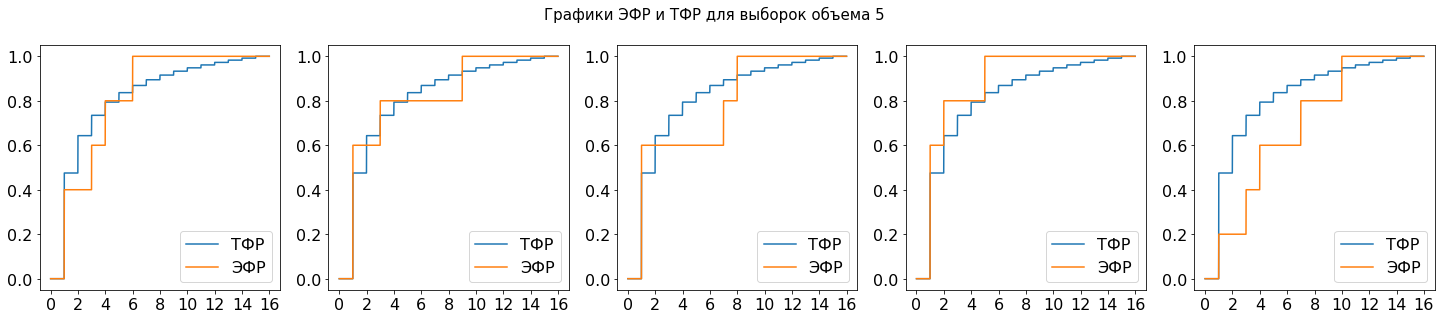

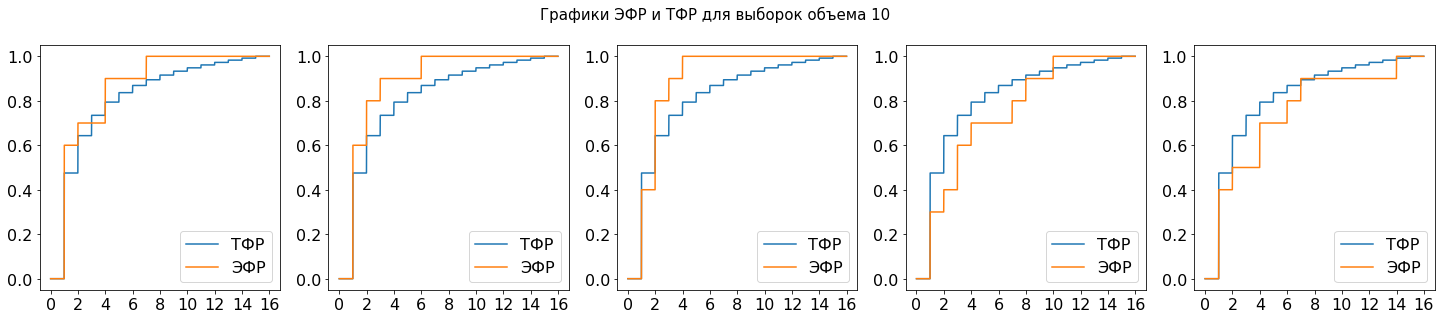

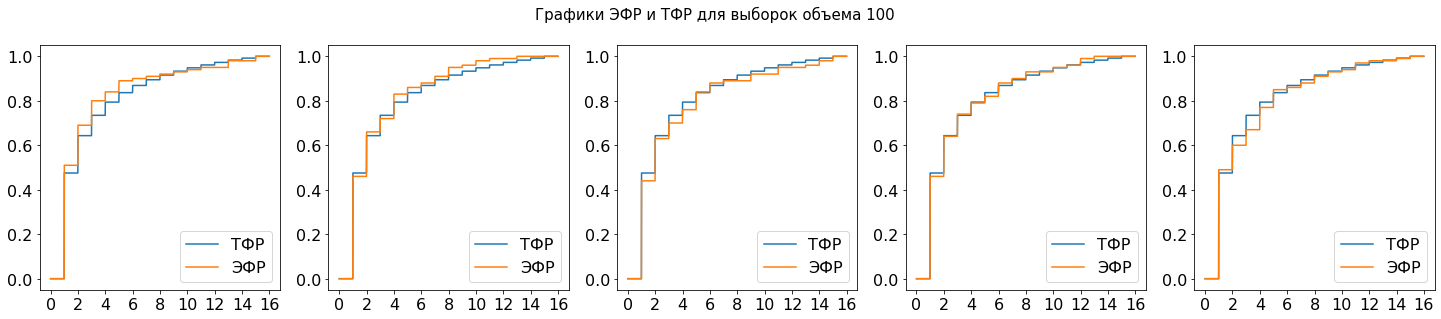

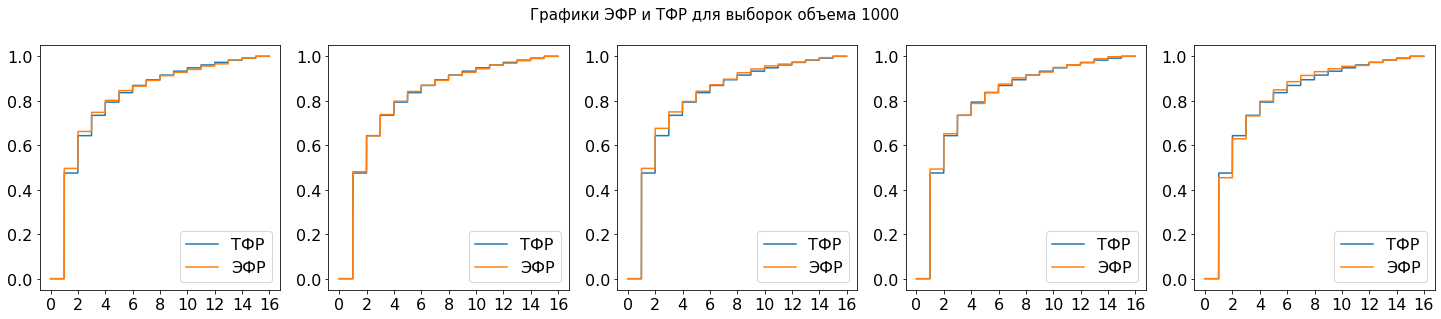

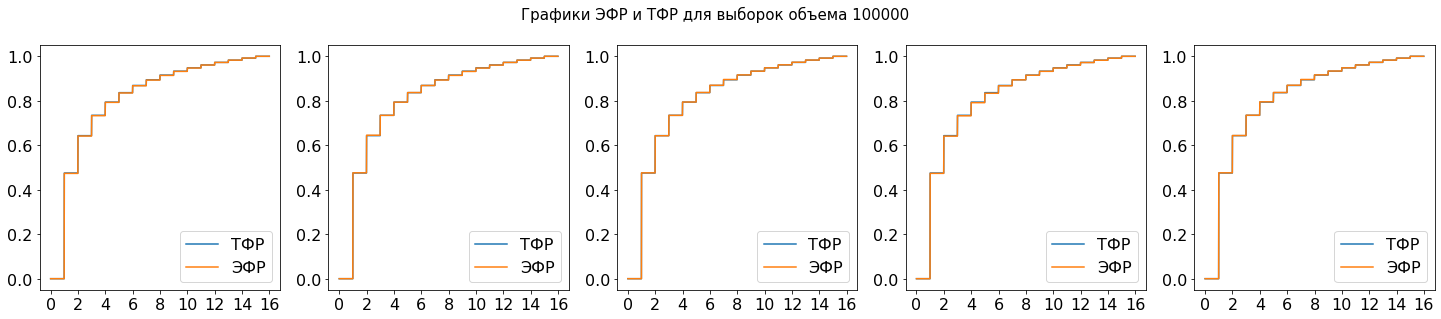

In [17]:
plot_all(var_series=zipf_var_series, cdf=zipf_cdf, x_values=np.arange(0, zipf_N + 1, 0.01), 
         x_ticks=range(0, zipf_N + 2, 2), s=zipf_s, N=zipf_N)

Точные верхние границы разности между всеми парами ЭФР ($C^{2}_{25}=300$ штук):

In [18]:
diffs = []
zipf_data = sum(list(zipf_var_series.values()), [])  # список всех 25 выборок
for i in range(len(zipf_data)):
    diffs.append([])
    for j in range(i + 1, len(zipf_data)):
        diffs[-1].append(find_max_diff(zipf_data[i], zipf_data[j]))
diffs = np.concatenate([np.around(entry, decimals=3) for entry in diffs])

In [19]:
diffs

array([0.2  , 0.4  , 0.4  , 0.4  , 0.3  , 0.4  , 0.4  , 0.3  , 0.2  ,
       0.29 , 0.26 , 0.23 , 0.24 , 0.2  , 0.262, 0.242, 0.276, 0.252,
       0.229, 0.242, 0.245, 0.243, 0.241, 0.244, 0.2  , 0.2  , 0.4  ,
       0.2  , 0.2  , 0.2  , 0.3  , 0.3  , 0.12 , 0.15 , 0.16 , 0.14 ,
       0.13 , 0.113, 0.119, 0.126, 0.115, 0.146, 0.127, 0.124, 0.124,
       0.126, 0.124, 0.4  , 0.4  , 0.3  , 0.4  , 0.4  , 0.3  , 0.2  ,
       0.3  , 0.28 , 0.28 , 0.28 , 0.26 , 0.266, 0.27 , 0.272, 0.275,
       0.286, 0.268, 0.269, 0.27 , 0.267, 0.27 , 0.6  , 0.1  , 0.1  ,
       0.2  , 0.4  , 0.3  , 0.11 , 0.14 , 0.17 , 0.18 , 0.2  , 0.154,
       0.158, 0.157, 0.162, 0.171, 0.165, 0.163, 0.163, 0.166, 0.163,
       0.5  , 0.6  , 0.6  , 0.2  , 0.3  , 0.49 , 0.46 , 0.43 , 0.44 ,
       0.4  , 0.462, 0.442, 0.476, 0.452, 0.429, 0.442, 0.445, 0.443,
       0.441, 0.444, 0.2  , 0.2  , 0.3  , 0.2  , 0.1  , 0.14 , 0.16 ,
       0.14 , 0.13 , 0.108, 0.119, 0.104, 0.112, 0.146, 0.127, 0.124,
       0.124, 0.126,

### 2.3 Построение вариационного ряда выборки

Ряды построили выше. Для выборок объемом 5:

In [20]:
zipf_var_series[5]

[[1, 1, 3, 4, 6],
 [1, 1, 1, 3, 9],
 [1, 1, 1, 7, 8],
 [1, 1, 1, 2, 5],
 [1, 3, 4, 7, 10]]

Для выборок объемом 10:

In [21]:
zipf_var_series[10]

[[1, 1, 1, 1, 1, 1, 2, 4, 4, 7],
 [1, 1, 1, 1, 1, 1, 2, 2, 3, 6],
 [1, 1, 1, 1, 2, 2, 2, 2, 3, 4],
 [1, 1, 1, 2, 3, 3, 4, 7, 8, 10],
 [1, 1, 1, 1, 2, 4, 4, 6, 7, 14]]

Выборочные квантили:

In [22]:
find_all_edf_quantiles(zipf_var_series)

Квантили 0.1:
Для выборок объемом 5:      [1.0, 1.0, 1.0, 1.0, 1.0];           среднее 1.0
Для выборок объемом 10:     [1.0, 1.0, 1.0, 1.0, 1.0];           среднее 1.0
Для выборок объемом 100:    [1.0, 1.0, 1.0, 1.0, 1.0];           среднее 1.0
Для выборок объемом 1000:   [1.0, 1.0, 1.0, 1.0, 1.0];           среднее 1.0
Для выборок объемом 100000: [1.0, 1.0, 1.0, 1.0, 1.0];           среднее 1.0
Квантили 0.5:
Для выборок объемом 5:      [3.0, 1.0, 1.0, 1.0, 4.0];           среднее 2.0
Для выборок объемом 10:     [1.0, 1.0, 2.0, 3.0, 3.0];           среднее 2.0
Для выборок объемом 100:    [1.0, 2.0, 2.0, 2.0, 2.0];           среднее 1.8
Для выборок объемом 1000:   [2.0, 2.0, 2.0, 2.0, 2.0];           среднее 2.0
Для выборок объемом 100000: [2.0, 2.0, 2.0, 2.0, 2.0];           среднее 2.0
Квантили 0.7:
Для выборок объемом 5:      [4.08, 3.24, 7.04, 2.12, 7.12];      среднее 4.72
Для выборок объемом 10:     [3.08, 2.0, 2.0, 5.62, 5.08];        среднее 3.556
Для выборок объемом 100:    [3.

Квантили распределения:

In [23]:
for quantile in [0.1, 0.5, 0.7]:
    print("Квантиль {}: {}".format(quantile, np.around(find_quantile_discrete_tdf(zipf_cdf, quantile, left=0, right=zipf_N, s=zipf_s, N=zipf_N), decimals=3)))

Квантиль 0.1: 1
Квантиль 0.5: 2
Квантиль 0.7: 3


### 2.4 Построение гистограммы и полигон частот

Построим для каждой из выборок полигон частот и рядом с ним на графике для сравнения построим график плотности вероятности. Для удобства график полигона частот нормирован так, чтобы сумма значений в точках, по которым он построен, примерно равнялась 1.

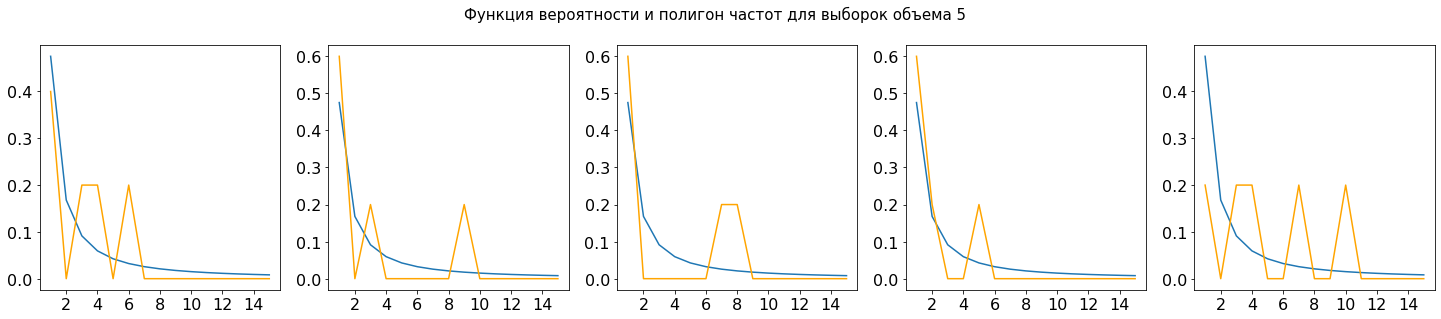

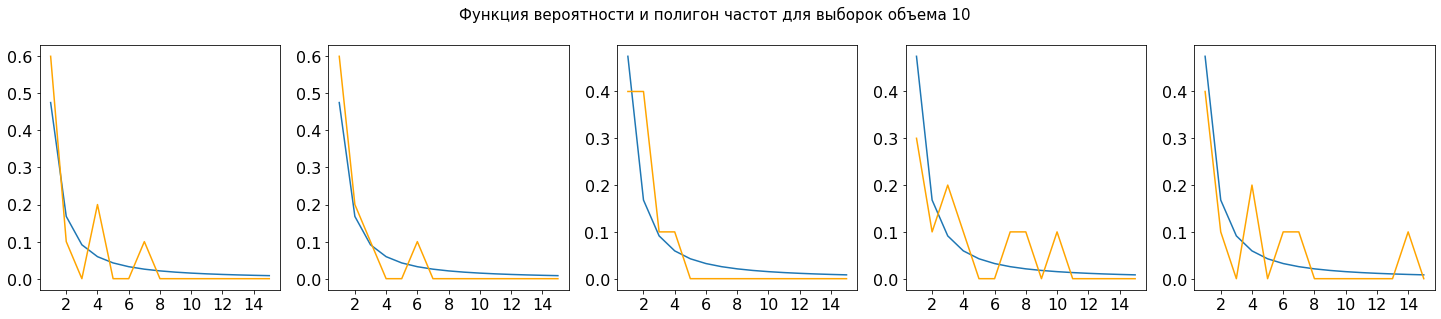

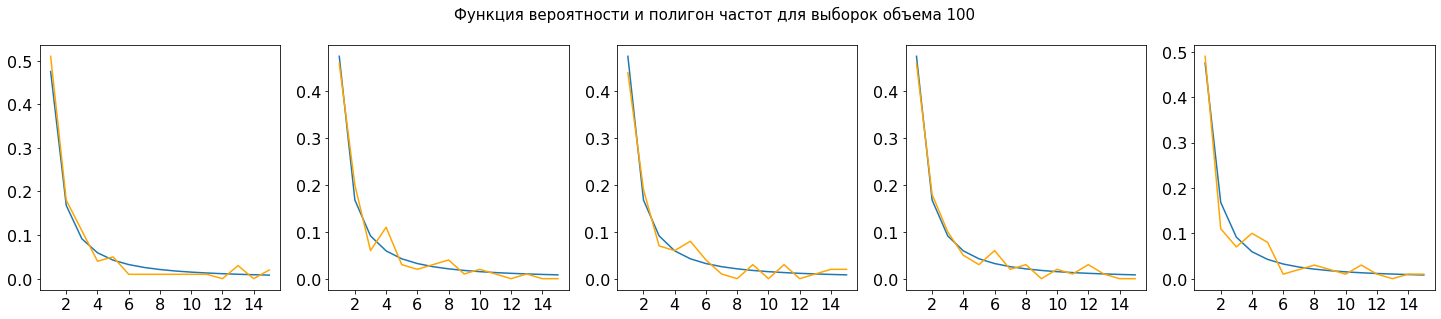

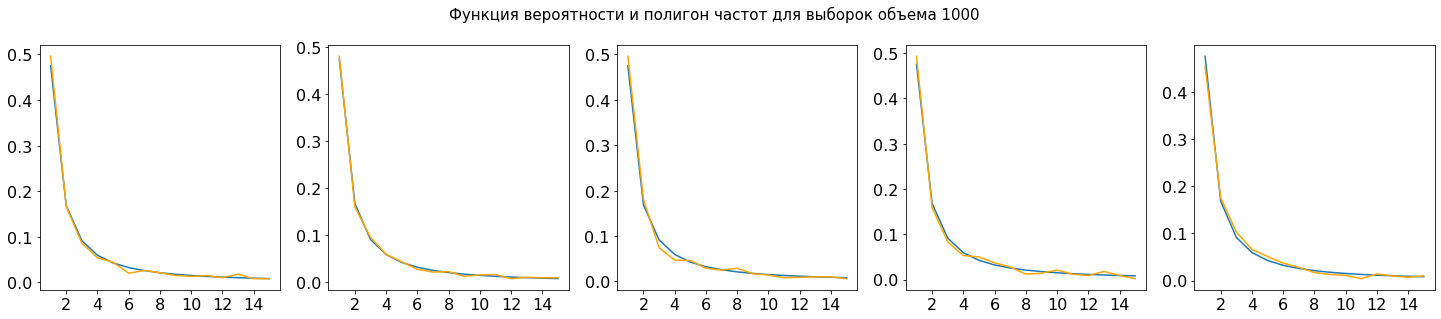

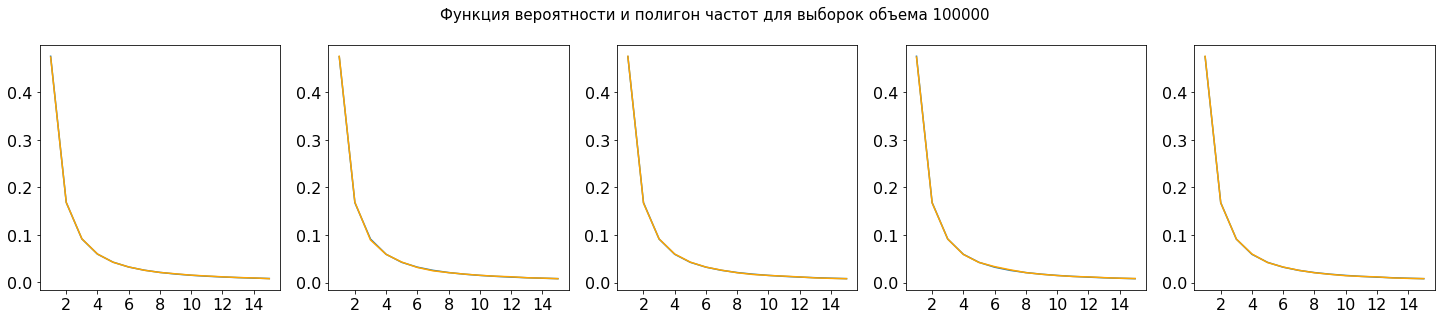

In [24]:
plot_polygon(var_series=zipf_var_series, pdf=zipf_pmf, x_values=np.arange(1, zipf_N + 1, 1), bar_count=15,
             x_ticks=range(0, zipf_N + 2, 2), is_discrete=True, s=zipf_s, N=zipf_N)

## Бета-распределение (абсолютно непрерывное)

In [25]:
# плотность вероятности
def beta_pdf(x, alpha, beta): return stats.beta.pdf(x, alpha, beta)
# функция распределения
def beta_cdf(x, alpha, beta): return special.betainc(alpha, beta, x)

### 2.1 Моделирование выбранных случайных величин
Выберем для моделирования параметры $a=5$ и $b=2$

In [26]:
def beta_random(a, b, size=1):
    ret = []
    l = a
    k = a + b - 1
    for _ in range(size):
        uni_set = stats.uniform.rvs(size=k)
        uni_set.sort()
        ret.append(uni_set[l-1])
    return ret

In [27]:
beta_a = 5
beta_b = 2
beta_samples = generate_samples(beta_random, a=beta_a, b=beta_b)

Выборки объема 5:

In [28]:
for entry in beta_samples[5]:
    print(np.around(entry, decimals=3))

[0.613 0.869 0.708 0.825 0.415]
[0.92  0.706 0.826 0.912 0.956]
[0.482 0.676 0.972 0.491 0.834]
[0.77  0.864 0.533 0.43  0.76 ]
[0.697 0.467 0.584 0.849 0.646]


Выборки объема 10:

In [29]:
for entry in beta_samples[10]:
    print(np.around(entry, decimals=3))

[0.59  0.655 0.909 0.803 0.808 0.812 0.995 0.838 0.707 0.838]
[0.8   0.329 0.601 0.8   0.8   0.896 0.831 0.912 0.632 0.593]
[0.724 0.702 0.753 0.624 0.44  0.816 0.793 0.714 0.781 0.527]
[0.748 0.83  0.618 0.945 0.585 0.874 0.536 0.916 0.744 0.873]
[0.639 0.737 0.957 0.863 0.631 0.691 0.749 0.715 0.895 0.438]


### 2.2 Построение эмпирической функции распределения

Построим вариационные ряды выборок (полезно это сделать прямо сейчас, а не в пункте 2.3):

In [30]:
beta_var_series = {}
for sample_size, samples in beta_samples.items():
    beta_var_series[sample_size] = [sorted(sample) for sample in samples]

#### График функции распределения

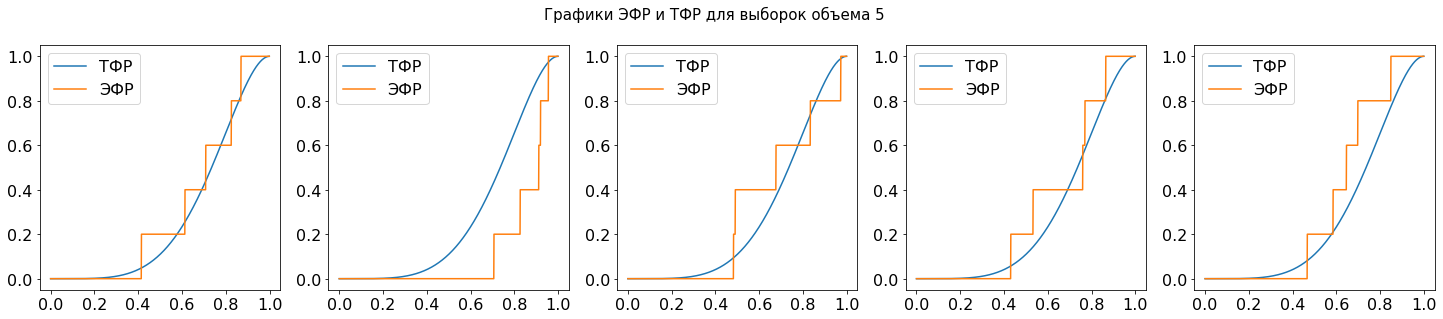

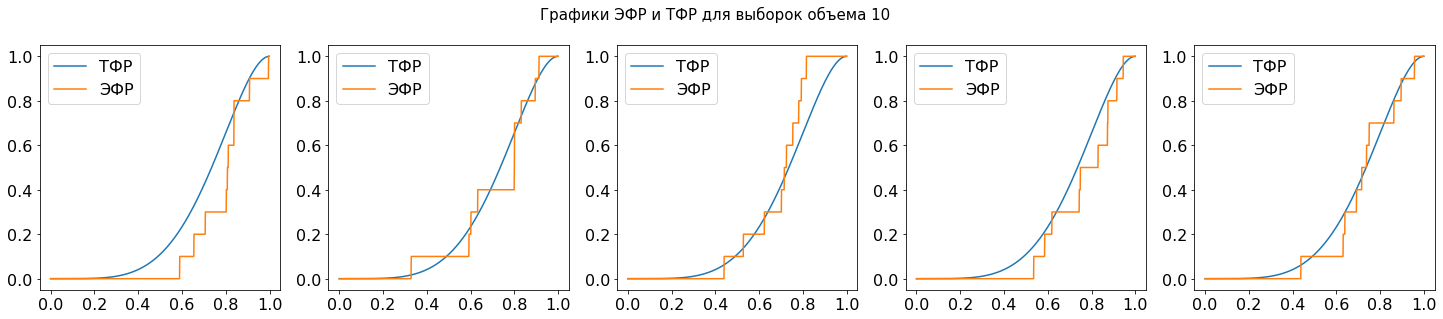

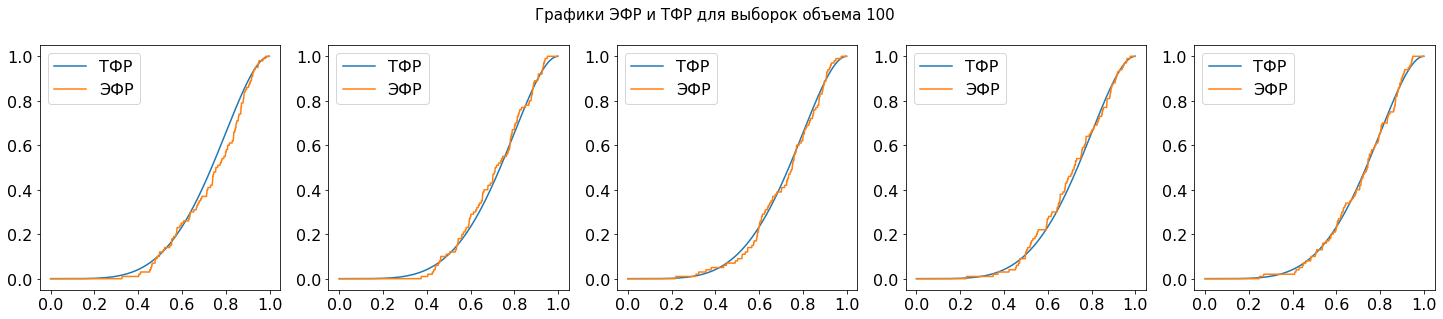

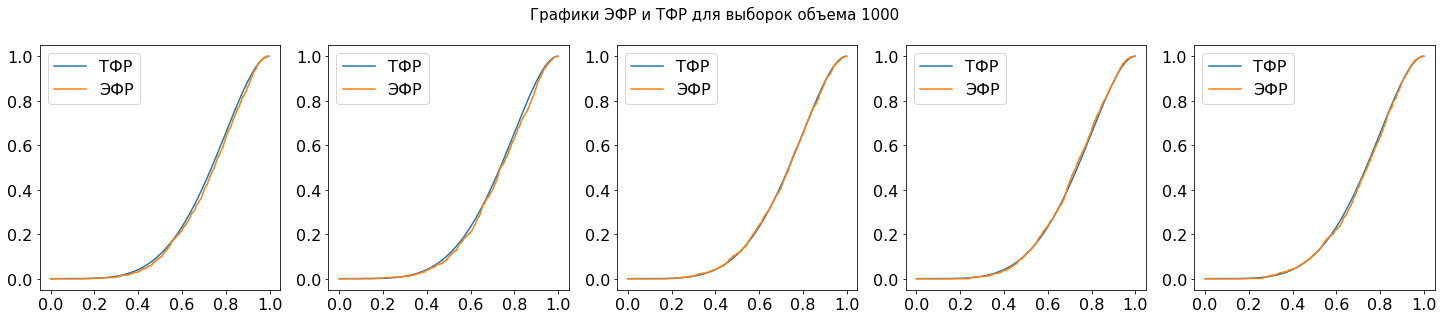

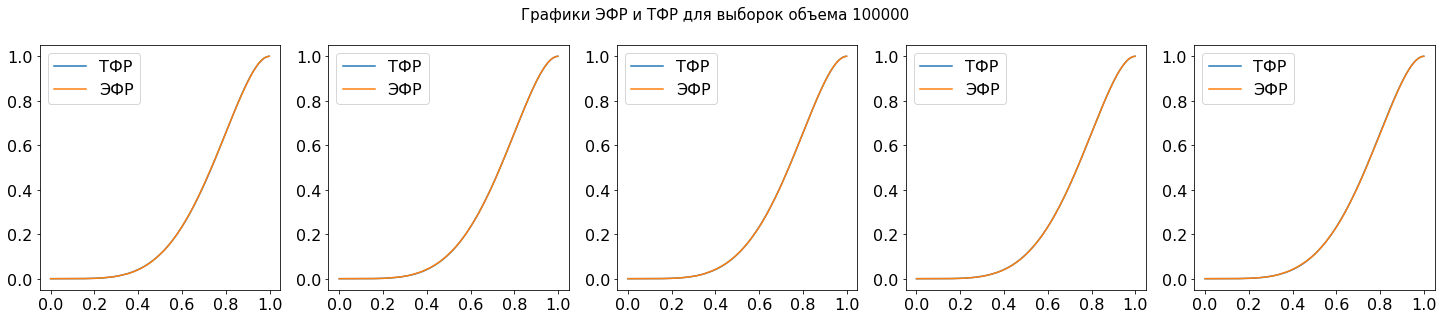

In [31]:
plot_all(var_series=beta_var_series, cdf=beta_cdf, x_values=np.arange(0, 1, 0.001),
         x_ticks=np.arange(0, 1.01, 0.2), alpha=beta_a, beta=beta_b)

Точные верхние границы разности между всеми парами ЭФР ($C^{2}_{25}=300$ штук):

In [32]:
diffs = []
beta_data = sum(list(beta_var_series.values()), [])  # список всех 25 выборок
for i in range(len(beta_data)):
    diffs.append([])
    for j in range(i + 1, len(beta_data)):
        diffs[-1].append(find_max_diff(beta_data[i], beta_data[j]))
diffs = np.concatenate([np.around(entry, decimals=3) for entry in diffs])

In [33]:
diffs

array([0.6  , 0.2  , 0.2  , 0.4  , 0.3  , 0.2  , 0.4  , 0.4  , 0.3  ,
       0.25 , 0.2  , 0.22 , 0.22 , 0.21 , 0.204, 0.222, 0.193, 0.179,
       0.191, 0.18 , 0.179, 0.178, 0.179, 0.181, 0.6  , 0.6  , 0.8  ,
       0.5  , 0.5  , 0.8  , 0.4  , 0.5  , 0.48 , 0.56 , 0.53 , 0.5  ,
       0.54 , 0.494, 0.493, 0.517, 0.537, 0.507, 0.519, 0.519, 0.519,
       0.52 , 0.517, 0.2  , 0.2  , 0.4  , 0.3  , 0.4  , 0.4  , 0.3  ,
       0.3  , 0.29 , 0.32 , 0.31 , 0.3  , 0.312, 0.313, 0.293, 0.301,
       0.299, 0.299, 0.298, 0.298, 0.299, 0.299, 0.4  , 0.5  , 0.4  ,
       0.3  , 0.4  , 0.3  , 0.29 , 0.27 , 0.29 , 0.23 , 0.27 , 0.267,
       0.273, 0.259, 0.256, 0.257, 0.257, 0.256, 0.257, 0.257, 0.257,
       0.6  , 0.4  , 0.5  , 0.5  , 0.4  , 0.43 , 0.37 , 0.41 , 0.34 ,
       0.4  , 0.413, 0.404, 0.396, 0.37 , 0.396, 0.384, 0.386, 0.387,
       0.386, 0.388, 0.4  , 0.6  , 0.2  , 0.4  , 0.27 , 0.39 , 0.35 ,
       0.37 , 0.37 , 0.34 , 0.338, 0.356, 0.379, 0.345, 0.361, 0.361,
       0.361, 0.363,

### 2.3 Построение вариационного ряда выборки

Ряды построили выше. Для выборок объемом 5:

In [34]:
for entry in beta_var_series[5]:
    print(np.around(entry, decimals=3))

[0.415 0.613 0.708 0.825 0.869]
[0.706 0.826 0.912 0.92  0.956]
[0.482 0.491 0.676 0.834 0.972]
[0.43  0.533 0.76  0.77  0.864]
[0.467 0.584 0.646 0.697 0.849]


Для выборок объемом 10:

In [35]:
for entry in beta_var_series[10]:
    print(np.around(entry, decimals=3))

[0.59  0.655 0.707 0.803 0.808 0.812 0.838 0.838 0.909 0.995]
[0.329 0.593 0.601 0.632 0.8   0.8   0.8   0.831 0.896 0.912]
[0.44  0.527 0.624 0.702 0.714 0.724 0.753 0.781 0.793 0.816]
[0.536 0.585 0.618 0.744 0.748 0.83  0.873 0.874 0.916 0.945]
[0.438 0.631 0.639 0.691 0.715 0.737 0.749 0.863 0.895 0.957]


Выборочные квантили:

In [36]:
find_all_edf_quantiles(beta_var_series)

Квантили 0.1:
Для выборок объемом 5:      [0.415, 0.706, 0.482, 0.43, 0.467];  среднее 0.5
Для выборок объемом 10:     [0.617, 0.44, 0.476, 0.557, 0.519];  среднее 0.522
Для выборок объемом 100:    [0.491, 0.474, 0.521, 0.498, 0.492]; среднее 0.495
Для выборок объемом 1000:   [0.508, 0.505, 0.479, 0.491, 0.488]; среднее 0.494
Для выборок объемом 100000: [0.49, 0.488, 0.489, 0.49, 0.489];   среднее 0.489
Квантили 0.5:
Для выборок объемом 5:      [0.708, 0.912, 0.676, 0.76, 0.646];  среднее 0.74
Для выборок объемом 10:     [0.81, 0.8, 0.719, 0.789, 0.726];    среднее 0.769
Для выборок объемом 100:    [0.759, 0.716, 0.751, 0.72, 0.742];  среднее 0.738
Для выборок объемом 1000:   [0.748, 0.738, 0.737, 0.728, 0.741]; среднее 0.738
Для выборок объемом 100000: [0.735, 0.735, 0.736, 0.735, 0.736]; среднее 0.735
Квантили 0.7:
Для выборок объемом 5:      [0.827, 0.921, 0.839, 0.773, 0.703]; среднее 0.813
Для выборок объемом 10:     [0.838, 0.817, 0.768, 0.874, 0.811]; среднее 0.822
Для выборок о

Квантили распределения:

In [37]:
for quantile in [0.1, 0.5, 0.7]:
    print("Квантиль {}: {}".format(quantile, np.around(find_quantile_continuous_tdf(beta_cdf, quantile, left=0, right=1, alpha=beta_a, beta=beta_b), decimals=3)))

Квантиль 0.1: 0.49
Квантиль 0.5: 0.735
Квантиль 0.7: 0.818


### 2.4 Построение гистограммы и полигон частот

Построим для каждой из выборок полигон частот и рядом с ним на графике для сравнения построим график плотности вероятности. Для удобства график полигона частот нормирован так, чтобы площадь под ним примерно равнялась 1

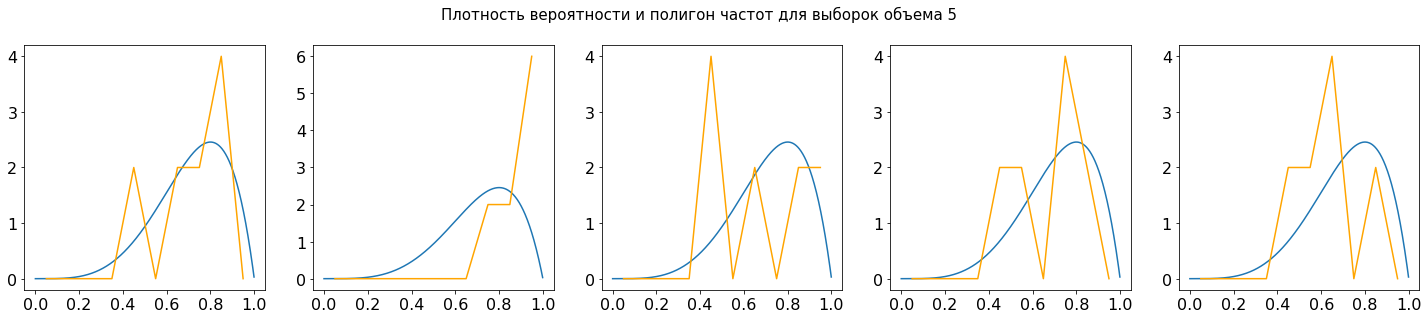

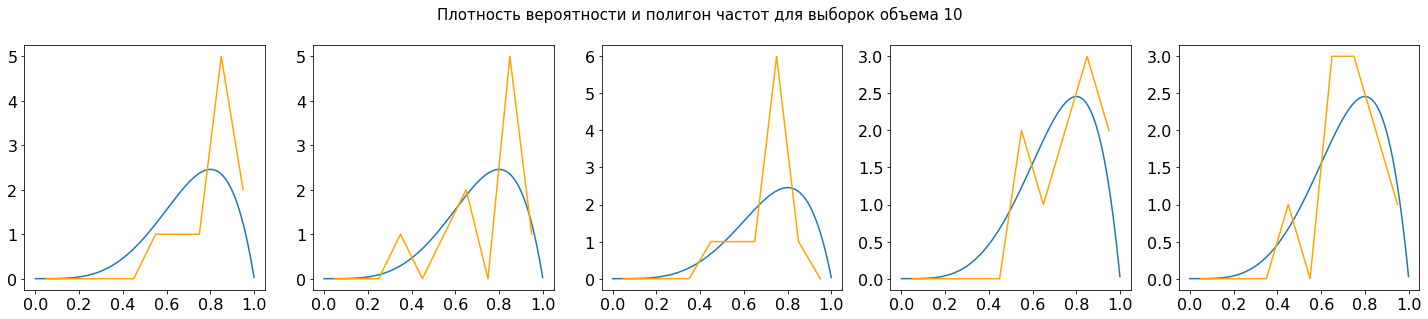

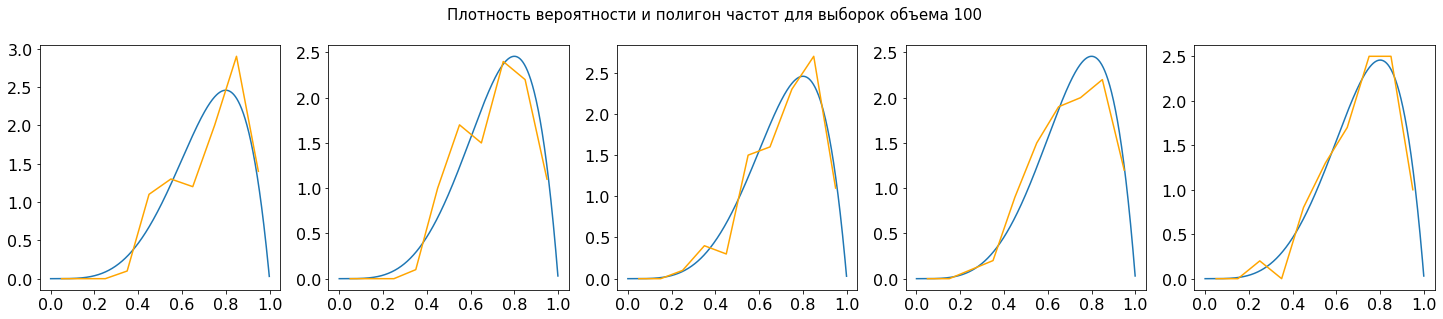

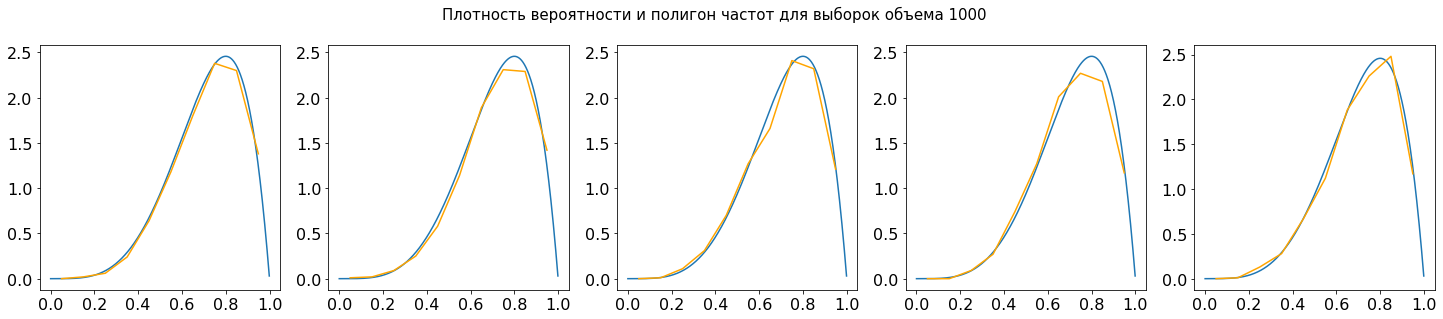

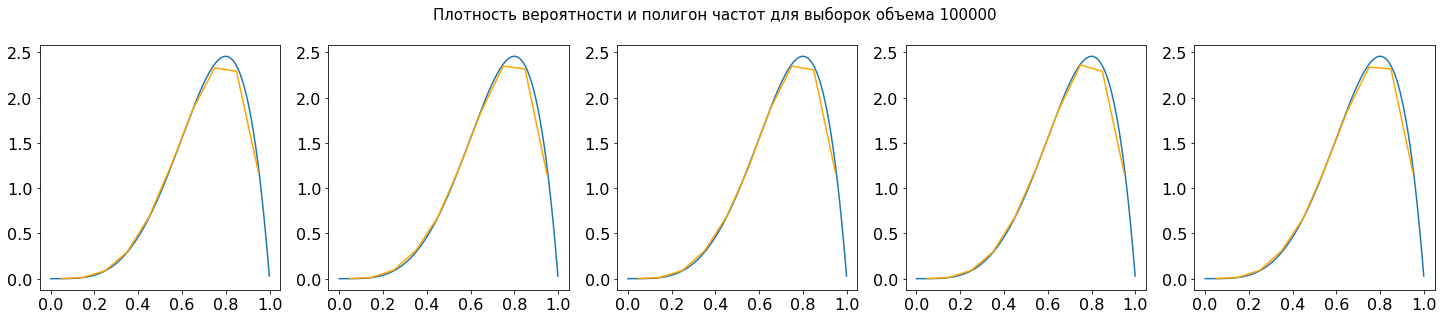

In [38]:
plot_polygon(var_series=beta_var_series, pdf=beta_pdf, x_values=np.arange(0, 1, 0.001), bar_count=10,
             x_ticks=np.arange(0, 1.01, 0.2), is_discrete=False, alpha=beta_a, beta=beta_b)